In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import gcpy

import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeat

def face_corners(lonb_face, latb_face):
    ny1, nx1 = lonb_face.shape
    ny, nx = ny1-1, nx1-1
    corners = {
        "NE": (lonb_face[0,0], latb_face[0,0]),
        "NW": (lonb_face[0,nx], latb_face[0,nx]),
        "SW": (lonb_face[ny,nx], latb_face[ny,nx]),
        "SE": (lonb_face[ny,0], latb_face[ny,0]),
    }
    return corners

def wrap180(lon):
    lon = (lon + 180.0) % 360.0 - 180.0
    # break lines that jump across the dateline
    jumps = np.where(np.abs(np.diff(lon)) > 180)[0]
    if jumps.size:
        lon = lon.astype(float)
        lon[jumps+1] = np.nan
    return lon

def face_outline(lonb_face, latb_face):
    """
    lonb_face, latb_face: (ny+1, nx+1) arrays of corner longitudes/latitudes (degrees)
    Returns 1D arrays (L,) for the closed outline order.
    """
    ny1, nx1 = lonb_face.shape
    ny, nx = ny1-1, nx1-1

    south  = [(0, i)     for i in range(0, nx+1)]
    east   = [(j, nx)    for j in range(1, ny+1)]
    north  = [(ny, i)    for i in range(nx-1, -1, -1)]
    west   = [(j, 0)     for j in range(ny-1, 0, -1)]
    idx = south + east + north + west

    lon = np.array([lonb_face[j, i] for (j, i) in idx], dtype=float)
    lat = np.array([latb_face[j, i] for (j, i) in idx], dtype=float)
    lon = wrap180(lon)
    return lon, lat

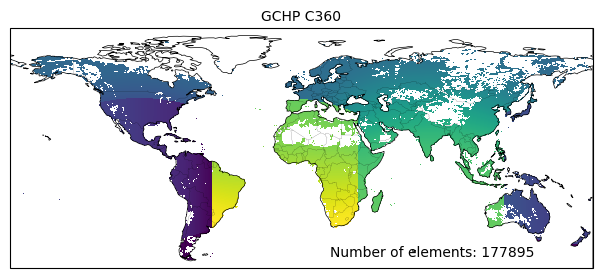

In [2]:
# get reference C360 corners
Dir = '/n/holylfs06/LABS/jacob_lab2/Lab/dzhang8/imi-gchp-test/'
c360_sv_dir = f'{Dir}output-gchp-local-soil/Test_Global_1month_c360/'
c360_sv_fpath = f'{c360_sv_dir}StateVector.1.68e-11.nc'
c360_sv_ds = xr.open_dataset(c360_sv_fpath).squeeze()
c360_sv_label = c360_sv_ds['StateVector'].values
c360_corner_lons = np.array(c360_sv_ds['corner_lons'])
c360_corner_lons[c360_corner_lons>180] -= 360
c360_corner_lats = c360_sv_ds['corner_lats'].values

c360_lons = np.array(c360_sv_ds['lons'])
c360_lons[c360_lons>180] -= 360
c360_lats = c360_sv_ds['lats'].values

# plot
extents = [-180, 180, -60, 88]
aspect = (extents[1] - extents[0]) / (extents[3] - extents[2])
proj = ccrs.PlateCarree()
trans = ccrs.Geodetic()

totwidth = 6.5
nrows, ncols = 1, 1
subwidth = totwidth / ncols
subheight = subwidth / aspect
totheight = subheight * nrows

fig, ax = plt.subplots(
    nrows, ncols,
    figsize=(totwidth, totheight),
    subplot_kw={'projection': proj},
    constrained_layout=True
)


ax.set_title('GCHP C360')    
ax.set_extent(extents, crs=proj)
ax.add_feature(cfeat.NaturalEarthFeature('physical', 'ocean', '110m', \
    edgecolor='black', facecolor='none', linewidth=.5))
ax.add_feature(cfeat.BORDERS, linewidth=.1)
ax.text(0.9, 0.05, f'Number of elements: {(c360_sv_label>0).sum()}',
    transform=ax.transAxes, ha='right', fontsize=10)

for f in range(6):
    corner_lonsf = c360_sv_ds['corner_lons'][f]
    corner_latsf = c360_corner_lats[f]
    sv_labelf = c360_sv_label[f]
    pcm = ax.pcolormesh(
        corner_lonsf, corner_latsf, sv_labelf,
        shading='auto',
        # cmap='RdYlBu_r',
        vmin=1,
        vmax=(c360_sv_label>0).sum(),
        transform=ccrs.PlateCarree()
    )

In [3]:
num_sv_thres = 5e-4 * (c360_sv_label>0).sum()

cs_res = 36
stretch_factor = 10.

start_lons = [-158, -158, -125, -120, -120, -112, -102, -90, -78, -78, -75, -68, -68, -70, -70, -68]
start_lats = [68, 59.76, 51.45, 43.11, 34.76, 26.4, 18.03, 9.66, 1.29, -7.08, -15.45, -23.82, -32.19, -40.55, -48.87]

target_lon = []
target_lat = []

for lati in range(len(start_lats)):
# for lati in [-1]:
    lon = start_lons[lati]
    lat = start_lats[lati]
    while lon < 180:
        temp_ds = gcpy.gen_grid(cs_res, stretch_factor, lon, lat)
        # target face id is 5
        lat_b = temp_ds['lat_b'].values[5,...]
        lon_b = temp_ds['lon_b'].values[5,...]
        coord_corners = face_corners(lon_b, lat_b)
        # print(f'coord_corners:\n{coord_corners}')
        lon_len = min(abs(coord_corners['SE'][0] - coord_corners['SW'][0]), 
                        abs(coord_corners['NE'][0] - coord_corners['NW'][0]))
        lat_len = min(abs(coord_corners['NW'][1] - coord_corners['SW'][1]), 
                        abs(coord_corners['NE'][1] - coord_corners['SE'][1]))
        ind = np.where((c360_lons>=np.nanmin(lon_b)) & (c360_lons<=np.nanmax(lon_b)) & 
                    (c360_lats>=np.nanmin(lat_b)) & (c360_lats<=np.nanmax(lat_b)))
        if ((c360_sv_label[ind]>0).sum() > num_sv_thres):
            target_lon.append(lon)
            target_lat.append(lat)
        
        lon += lon_len
    print(f'Latitude range: {lat_len}')

print(f'Number of target faces: {len(target_lon)}')
print(f'Latitude range: {lat_len}')
print(f'Target lon: {target_lon}')
print(f'Target lat: {target_lat}')

Latitude range: 8.23505320477824
Latitude range: 8.30733569566111
Latitude range: 8.338249222386487
Latitude range: 8.353998490054401
Latitude range: 8.362885411007433
Latitude range: 8.368176903497694
Latitude range: 8.371335666085173
Latitude range: 8.373066180194723
Latitude range: 8.373706038861627
Latitude range: 8.37337069317938
Latitude range: 8.372000264993769
Latitude range: 8.369335630837544
Latitude range: 8.364806122697178
Latitude range: 8.357247856397073
Latitude range: 8.344194501887777
Number of target faces: 249
Latitude range: 8.344194501887777
Target lon: [-158, -139.16994475210487, -120.33988950420974, -101.50983425631458, 11.47049723105621, 30.30055247895135, 49.13060772684649, 67.96066297474161, 86.79071822263674, 105.62077347053189, 124.45082871842702, 143.28088396632214, 162.11093921421727, -158, -143.2483847643209, -128.49676952864178, -113.74515429296265, -98.99353905728353, -84.2419238216044, -69.49030858592528, -10.4838476432088, 4.267767592470326, 19.019382

In [4]:
temp_lat = -40.8
temp_lon = -70
temp_ds = gcpy.gen_grid(cs_res, stretch_factor, temp_lon, temp_lat)
# target face id is 5
lat_b = temp_ds['lat_b'].values[5,...]
lon_b = temp_ds['lon_b'].values[5,...]
coord_corners = face_corners(lon_b, lat_b)
# print(f'coord_corners:\n{coord_corners}')
lon_len = min(abs(coord_corners['SE'][0] - coord_corners['SW'][0]), 
                abs(coord_corners['NE'][0] - coord_corners['NW'][0]))
temp_lon += lon_len
print(temp_lon)

lat_len = min(abs(coord_corners['NW'][1] - coord_corners['SW'][1]), 
                        abs(coord_corners['NE'][1] - coord_corners['SE'][1]))
temp_lat -= lat_len
print(temp_lat)

-59.57954091036616
-49.156954241588046


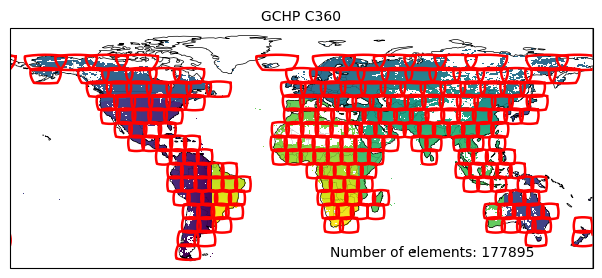

In [4]:
# plot
cs_res = 36
stretch_factor = 10.
extents = [-180, 180, -60, 88]
aspect = (extents[1] - extents[0]) / (extents[3] - extents[2])
proj = ccrs.PlateCarree()
trans = ccrs.Geodetic()

totwidth = 6.5
nrows, ncols = 1, 1
subwidth = totwidth / ncols
subheight = subwidth / aspect
totheight = subheight * nrows

fig, ax = plt.subplots(
    nrows, ncols,
    figsize=(totwidth, totheight),
    subplot_kw={'projection': proj},
    constrained_layout=True
)


ax.set_title('GCHP C360')    
ax.set_extent(extents, crs=proj)
ax.add_feature(cfeat.NaturalEarthFeature('physical', 'ocean', '110m', \
    edgecolor='black', facecolor='none', linewidth=.5))
ax.add_feature(cfeat.BORDERS, linewidth=.1)
ax.text(0.9, 0.05, f'Number of elements: {(c360_sv_label>0).sum()}',
    transform=ax.transAxes, ha='right', fontsize=10)

for f in range(6):
    corner_lonsf = c360_sv_ds['corner_lons'][f]
    corner_latsf = c360_corner_lats[f]
    sv_labelf = c360_sv_label[f]
    pcm = ax.pcolormesh(
        corner_lonsf, corner_latsf, sv_labelf,
        shading='auto',
        # cmap='RdYlBu_r',
        vmin=1,
        vmax=(c360_sv_label>0).sum(),
        transform=ccrs.PlateCarree()
    )

# read target coords
supDir = f"{Dir}supportData/"
coord_fpath = supDir + 'target_coords.csv'
coord_df = pd.read_csv(coord_fpath)
target_lats = coord_df['Target_lat'].values.astype(float)
target_lons = coord_df['Target_lon'].values.astype(float)
for ti in range(len(target_lats)):
    temp_ds = gcpy.gen_grid(cs_res, stretch_factor, target_lons[ti], target_lats[ti])
    for f in [5]:
        lon, lat = face_outline(temp_ds['lon_b'].values[f], temp_ds['lat_b'].values[f])
        ax.plot(lon, lat, transform=ccrs.PlateCarree(), lw=1.8, color='red')
